# ConvoKit Forecaster framework: TransformerEncoderModel demo

The `Forecaster` class provides a generic interface to *conversational forecasting models*, a class of models designed to computationally capture the trajectory of conversations in order to predict future events. Though individual conversational forecasting models can get quite complex, the `Forecaster` API abstracts away the implementation details into a standard fit-transform interface. To demonstrate the power of this framework, this notebook walks through an example of fine-tuning the `TransformerEncoderModel` (including all BERT-styled models: `BERT`, `RoBERTa`, `SpanBERT`, `DeBERTa`, ...) conversational forecasting model on the CGA-CMV corpus. You will see how the `Forecaster` API allows us to load the data, select training, validation, and testing samples, train the `TransformerEncoder` Model, and perform evaluation - replicating the original paper's full pipeline (minus pre-training, which is considered outside the scope of ConvoKit) all in only a few lines of code!

Let's start by importing the necessary ConvoKit classes and functions, and loading the CGA-CMV corpus.

In [2]:
from convokit import (download,
                      Corpus,
                      Forecaster,
                      TransformerEncoderModel,
                      TransformerForecasterConfig,
)
from functools import partial
import json, os

/reef/conda-envs/sqt-env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/sqt2/ConvoKit/convokit/forecaster/TransformerDecoderModel.py:1: UserWarning: WARNING: Unsloth should be imported before transformers, peft to ensure all optimizations are applied. Your code may run slower or encounter memory issues without these optimizations.

Please restructure your imports with 'import unsloth' at the top of your file.
  from unsloth import FastLanguageModel, is_bfloat16_supported


🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!


In [3]:
corpus = Corpus(filename=download("conversations-gone-awry-cmv-corpus", data_dir="YOUR_DATA_DIRECTORY"))
label_metadata = "has_removed_comment" # if 'cmv' in corpus_name
# label_metadata = "conversation_has_personal_attack" # else


Dataset already exists at /home/sqt2/ConvoKit/examples/forecaster/YOUR_DATA_DIRECTORY/conversations-gone-awry-cmv-corpus


## Define selectors for the Forecaster

Core to the flexibility of the `Forecaster` framework is the concept of *selectors*. 

To capture the temporal dimension of the conversational forecasting task, `Forecaster` iterates through conversations in chronological utterance order, at each step presenting to the backend forecasting model a "context tuple" containing both the comment itself and the full "context" preceding that comment. As a general framework, `Forecaster` on its own does not try to make any further assumptions about what "context" should contain or look like; it simply presents context as a chronologically ordered list of all utterances up to and including the current one. 

But in practice, we often want to be pickier about what we mean by "context". At a basic level, we might want to select only specific contexts during training versus during evaluation. The simplest version of this is the desire to split the conversations by training and testing splits, but more specifically, we might also want to select only certain contexts within a conversation. This is necessary for TransformerEncoderModel training, which works by taking only the chronologically last context (i.e., all utterances up to and not including the toxic comment, or up to the end of the conversation) as a labeled training instance. This is where selectors come in! A selector is a user-provided function that takes in a context and returns a boolean representing whether or not that context should be used. You can provide separate selectors for `fit` and `transform`, and `fit` also takes in a second selector that you can use to define validation data.

Here we show how to implement the necessary selectors for TransformerEncoderModel.

In [4]:
def generic_fit_selector(context_tuple):
    """
    We use this generic function for both training and validation data.
    In both cases, its job is to select only those contexts for which the
    FUTURE context is empty. This is in accordance with how CRAFT Model was
    originally trained on CGA-CMV, taking the last context from each
    conversation ("last" defined as being up to and including the chronologically
    last utterance as recorded in the corpus)
    """
    matches_split = (context_tuple.current_utterance.get_conversation().meta["split"] == "train")
    is_end = (len(context_tuple.future_context) == 0)
    return (matches_split and is_end)
def eval_selector(context_tuple):

    return (context_tuple.current_utterance.get_conversation().meta["split"] == "val")
def transform_selector(context_tuple):
    """
    For transform we only need to check that the conversation is in the test split
    """
    return (context_tuple.current_utterance.get_conversation().meta["split"] == "test")

## Initialize the Forecaster and TransformerEncoderModel backend

Now the rest of the process is pretty straightforward! We simply need to:
1. Initialize a backend `ForecasterModel` for the `Forecaster` to use, in this case we choose ConvoKit's implementation of TransformerEncoderModel.
2. Initialize a `Forecaster` instance to wrap that `ForecasterModel` in a generic fit-transform API

In [5]:
# We define the constant DEVICE to specify whether we want to run in GPU mode or CPU mode. As CRAFT is a neural model, GPU mode
# (activated with the value "cuda") is preferred. But if your machine lacks a GPU, you can change the value to "cpu" to enable
# CPU mode (noting that it will be slower)
DEVICE = "cuda"

In [6]:
model_name_or_path = 'roberta-base'
"""
List of models that we use this class to benchmark:
bert-base-cased
bert-large-cased
roberta-base
roberta-large
SpanBERT/spanbert-base-cased
SpanBERT/spanbert-large-cased
microsoft/deberta-v3-base
microsoft/deberta-v3-large
"""
saving_directory = "YOUR_SAVING_DIRECTORY"
config_dict = TransformerForecasterConfig(
                    output_dir=saving_directory,
                    per_device_batch_size=4,
                    gradient_accumulation_steps=1,
                    num_train_epochs=4,
                    learning_rate=6.7e-6,
                    random_seed=1,
                    context_mode="normal",
                    device=DEVICE,
    )
encoder_model = TransformerEncoderModel(model_name_or_path, config=config_dict)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
encoder_forecaster = Forecaster(encoder_model, label_metadata)

## Fine-tune the model using Forecaster.fit

And now, just like any other ConvoKit Transformer, model training is done simply by calling `fit` (note how we pass in the selectors we previously defined!)...

In [8]:
encoder_forecaster.fit(corpus,
                     partial(generic_fit_selector),
                     val_context_selector=partial(eval_selector))

Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Step,Training Loss
1027,0.660000
2054,0.598500
3081,0.566800
4108,0.574900


100%|██████████| 8613/8613 [01:20<00:00, 107.08it/s]


Accuracy: checkpoint-1027 0.6637426900584795


100%|██████████| 8613/8613 [01:20<00:00, 107.50it/s]


Accuracy: checkpoint-2054 0.6710526315789473


100%|██████████| 8613/8613 [01:20<00:00, 106.71it/s]


Accuracy: checkpoint-3081 0.6739766081871345


100%|██████████| 8613/8613 [01:20<00:00, 107.48it/s]


Accuracy: checkpoint-4108 0.6812865497076024


100%|██████████| 8613/8613 [01:19<00:00, 107.89it/s]


Deleting: YOUR_SAVING_DIRECTORY/checkpoint-1027
Deleting: YOUR_SAVING_DIRECTORY/checkpoint-2054
Deleting: YOUR_SAVING_DIRECTORY/checkpoint-3081


## Run the fitted model on the test set and perform evaluation

...and inference is done simply by calling `transform`! (again, note the selector)

### Normal Model

In [9]:
config_dict = TransformerForecasterConfig(       # We can remove parameters for training/fine-tuning now.
                output_dir=saving_directory,
                context_mode="normal",
                device=DEVICE,
)
config_file = os.path.join(saving_directory, "dev_config.json")
with open(config_file, 'r') as file:
    model_config = json.load(file)
normal_model = TransformerEncoderModel(os.path.join(saving_directory, model_config['best_checkpoint']), config=config_dict)
normal_model.best_threshold = model_config['best_threshold']
normal_bert_forecaster = Forecaster(normal_model, label_metadata)

In [10]:
corpus = normal_bert_forecaster.transform(corpus, transform_selector)

100%|██████████| 8466/8466 [01:18<00:00, 107.65it/s]


Finally, to get a human-readable interpretation of model performance, we can use `summarize` to generate a table of standard performance metrics. It also returns a table of conversation-level predictions in case you want to do more complex analysis!

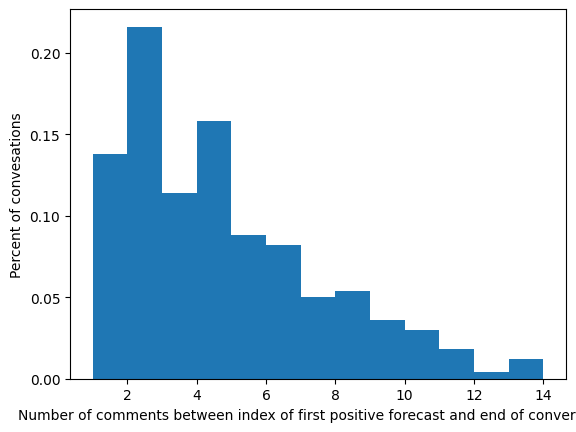

Horizon statistics (# of comments between first positive forecast and conversation end):
Mean = 3.330677290836653, Median = 3.0
Accuracy                                                          0.66886
Precision                                                        0.649418
Recall                                                           0.733918
FPR                                                              0.396199
F1                                                               0.689087
Mean H                                                           3.330677
Correct Adjustment                                               0.075292
Incorrect Adjustment                                              0.05117
Recovery                                                         0.024123
Leaderboard String      | MODEL_NAME     | 66.9   | 64.9  | 73.4 | 68....
dtype: object


(                 label     score  forecast  last_utterance_forecast
 conversation_id                                                    
 cus26gy              1  0.981455       1.0                      1.0
 cus37h0              1  0.979289       1.0                      1.0
 cus142u              0  0.951290       1.0                      0.0
 cus19ml              0  0.966012       1.0                      0.0
 cusxft0              1  0.031078       0.0                      0.0
 ...                ...       ...       ...                      ...
 e8qli0i              0  0.046534       0.0                      0.0
 e8qm4aj              0  0.044379       0.0                      0.0
 e8ql8ii              0  0.937213       1.0                      1.0
 e8qzjei              1  0.980753       1.0                      1.0
 e8r00ko              0  0.899094       1.0                      0.0
 
 [1368 rows x 4 columns],
 {'Accuracy': np.float64(0.668859649122807),
  'Precision': np.float64(0.64

In [11]:
normal_bert_forecaster.summarize(corpus, lambda c: c.meta['split'] == "test")

### No-Context Model

Capturing conversational context and dynamics is a critical aspect of conversational forecast models. To evaluate whether a model possesses this capability, we introduce the No-Context Setting, where models are deprived of access to conversational history. Specifically, instead of providing the full context, we feed only the most recent utterance at each timestamp, removing any contextual information about prior interactions.

In [12]:
config_dict = TransformerForecasterConfig(
                output_dir=f"${saving_directory}/no-context",
                context_mode="no-context",
                device=DEVICE,
)
config_file = os.path.join(saving_directory, "dev_config.json")
with open(config_file, 'r') as file:
    model_config = json.load(file)
nocontext_model = TransformerEncoderModel(os.path.join(saving_directory, model_config['best_checkpoint']), config=config_dict)
nocontext_model.best_threshold = model_config['best_threshold']
nocontext_bert_forecaster = Forecaster(nocontext_model, label_metadata)

In [13]:
corpus = nocontext_bert_forecaster.transform(corpus, transform_selector)

100%|██████████| 8466/8466 [01:18<00:00, 108.09it/s]


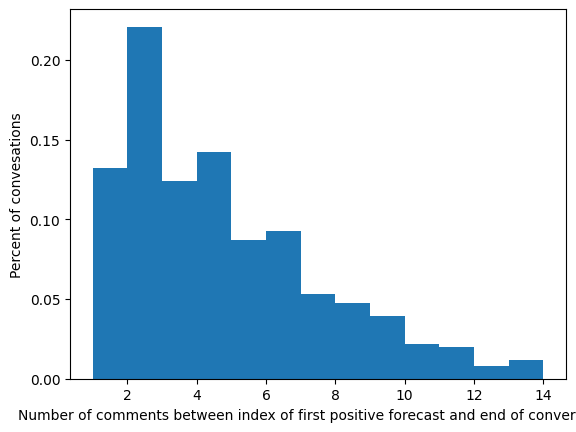

Horizon statistics (# of comments between first positive forecast and conversation end):
Mean = 3.3398821218074657, Median = 3.0
Accuracy                                                         0.662281
Precision                                                        0.639447
Recall                                                           0.744152
FPR                                                              0.419591
F1                                                               0.687838
Mean H                                                           3.339882
Correct Adjustment                                                0.13231
Incorrect Adjustment                                             0.164474
Recovery                                                        -0.032164
Leaderboard String      | MODEL_NAME     | 66.2   | 63.9  | 74.4 | 68....
dtype: object


(                 label     score  forecast  last_utterance_forecast
 conversation_id                                                    
 cus26gy              1  0.970378       1.0                      0.0
 cus37h0              1  0.978524       1.0                      0.0
 cus142u              0  0.832511       1.0                      0.0
 cus19ml              0  0.966012       1.0                      0.0
 cusxft0              1  0.212632       0.0                      0.0
 ...                ...       ...       ...                      ...
 e8qli0i              0  0.046534       0.0                      0.0
 e8qm4aj              0  0.044379       0.0                      0.0
 e8ql8ii              0  0.603942       0.0                      0.0
 e8qzjei              1  0.980753       1.0                      1.0
 e8r00ko              0  0.899094       1.0                      0.0
 
 [1368 rows x 4 columns],
 {'Accuracy': np.float64(0.6622807017543859),
  'Precision': np.float64(0.6

In [14]:
nocontext_bert_forecaster.summarize(corpus, lambda c: c.meta['split'] == "test")